In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
from models.GPT4TS import GPT4TS
from data_provider.data_factory import data_provider
from data_provider.data_loader import Dataset_Custom
import argparse
from utils.tools import test_1, StandardScaler, test
import pickle as pkl
import os
from einops import rearrange
%matplotlib inline
plt.rcParams['savefig.facecolor'] = "0.8"
device = torch.device('cuda:0')
from utils.post import RMSE, visual
from scipy.stats import norm
import scipy.stats as st
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
from scipy.stats import gaussian_kde
import scipy
from ts2vg import NaturalVG
# import talib as ta
import networkx as nx
from tsfracdiff import FractionalDifferentiator, ADFuller, PhillipsPerron
from scipy.ndimage import uniform_filter1d

/home/leo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
URT = 'ADF'
from utils.metrics import RMSE, SMAPE

def get_price_data(test_data, preds : np.array, trues : np.array, index = 2, URT = 'ADF', pred_len = 7):
    fracdiff2 = FractionalDifferentiator(maxOrderBound= 1, precision = 0.01, memoryThreshold= 0.001, unitRootTest= URT)
    with open(f'./datasets/BTC/params_diff_{URT}.pkl', 'rb') as file :
        Info = pkl.load(file)
    fracdiff2.orders = Info['orders'][3:4]
    fracdiff2.numLags = Info['numLags'][3:4]
    fracdiff2.isFitted = True
    numLags = fracdiff2.numLags[0]
    f = test_data.data_stamp
    i = f[index]-1
    df = pd.read_csv(f'datasets/BTC/BTC_Daily_sentiment_newer.csv')
    input = df.iloc[i:i+args.seq_len+1][['open', 'high', 'low', 'close']].values
    close_lag = input[-numLags:,-1]
    true = fracdiff2.InverseTransform(trues[index], close_lag)[-pred_len:].to_numpy().squeeze(axis = 1)
    pred = fracdiff2.InverseTransform(preds[index], close_lag)[-pred_len:].to_numpy().squeeze(axis = 1)
    return input, true, pred

def plot(lookback = 50, pred_len = 7, trues = '',preds = '', feat = 'close', test_data = 0, indexplot = 0, c = 'yellow'):
    input, trueq, predq = get_price_data(test_data=test_data, preds = preds[:,:,-1], trues = trues[:,:,-1], index = indexplot, URT = URT, pred_len = pred_len)
    truth = input[-lookback:,3]
    opens = input[-lookback:,0]
    highs = input[-lookback:,1]
    lows = input[-lookback:,2]
    features = {'close': -1, 'open': 0, 'high': 2, 'low':1}

    # RMSE2 = []
    # for i in range(450):
    #     inputx, true, pred = get_price_data(test_data=test_data, preds = preds[:,:,-1], trues = trues[:,:,-1], index = i, pred_len=pred_len)
    #     res = pred-true
    #     RMSE2.append(res)
    # RMSE2 = np.array(RMSE2)
    # RMSE2 = np.std(RMSE2, axis = 0)

    # predq = [truth[-1] for i in range(pred_len)] ### For naïve

    RMSEi = RMSE(trueq, predq)
    SMAPEi = SMAPE(trueq, predq)

    # plt.figure(dpi = 400)
    # plt.xlabel('Time (hours))')
    # plt.ylabel('Price (USD)')
    trueq = np.append(input[:,-1],trueq, axis = 0)[-pred_len-1:]
    predq = np.append(input[:,-1],predq, axis = 0)[-pred_len-1:]
    height = truth - opens
    bottom = np.where(height > 0, opens, truth + abs(height))
    color = np.where(height > 0, 'g', 'r')
    # plt.bar(range(len(truth)), height, bottom=bottom, color=color, align='center')
    # plt.vlines(range(len(highs)), ymin=lows, ymax=highs, color=color, linewidth=0.5)
    # plt.plot(range(lookback-1, lookback+pred_len),trueq, label = f'true {feat}', color = 'b')
    # plt.plot(range(lookback-1, lookback+pred_len),predq, label = f'prediction', color = 'r')   
    # # plt.fill_between(range(lookback, lookback + pred_len), predq[1:] - RMSE2, predq[1:] + RMSE2, alpha=0.2, color='red', label='68% confidence')
    # plt.legend(loc = 'upper left')
    # plt.grid(visible = True)
    # plt.title(f'plot of prediction at index {indexplot}')

    return RMSEi, SMAPEi

data = f'llamatest_BTC_Daily_fracdiffnodata.csv_voc200_seq110_patch11_pred7_stride2_itr0'
# data = f'llamatest_BTC_Daily_fracdiffnodata.csv_voc200_seq50_patch11_pred1_stride2_itr0'
with open(f'./datasets/results/{data}.pkl', 'rb') as file :
    res = pkl.load(file)
    preds = res ['preds'] 
    trues = res ['trues']
    inputx = res['inputx']

datas = f'args_BTC_Daily_fracdiffsenttest.csv.pkl'
with open(datas, 'rb') as f :
    args = pkl.load(f)
if args.freq == 0 :
    args.freq = 'h'
print("args: ", args.__dict__)
# args.seq_len = 110
# args.pred_len = 7
# args.batch_size = 1
# args.patch_size = 11
args.data_path = f'BTC_Daily_fracdiffnodata.csv'
print("args: ", args.__dict__)
test_data, test_loader = data_provider(args, 'test')

args:  {'model_id': 'BTC_Daily_fracdiffsenttest.csv_llamatest__200_15_12', 'checkpoints': './checkpoints/', 'root_path': './datasets/BTC/', 'data_path': 'BTC_Daily_fracdiffsenttest.csv', 'data': 'custom', 'features': 'M', 'freq': 'h', 'target': 'close', 'embed': 'timeF', 'percent': 100, 'seq_len': 200, 'pred_len': 15, 'label_len': 7, 'scale': 1, 'decay_fac': 0.9, 'learning_rate': 0.0001, 'batch_size': 5, 'num_workers': 10, 'train_epochs': 10, 'lradj': 'type2', 'patience': 3, 'gpt_layers': 12, 'is_gpt': 0, 'isllama': 1, 'e_layers': 3, 'd_model': 5120, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.05, 'enc_in': 7, 'c_out': 7, 'patch_size': 12, 'kernel_size': 25, 'pct': 0, 'pca': 1, 'loss_func': 'mse', 'pretrain': 1, 'freeze': 1, 'model': 'llamatest', 'stride': 2, 'max_len': -1, 'hid_dim': 16, 'tmax': 10, 'voc': 1000, 'itr': 1, 'cos': 0}
args:  {'model_id': 'BTC_Daily_fracdiffsenttest.csv_llamatest__200_15_12', 'checkpoints': './checkpoints/', 'root_path': './datasets/BTC/', 'data_path': 'BTC_

In [3]:
test_data.data_x.shape

(660, 9)

In [4]:
Trues = [] ; Preds = [] ; y = [] ; Preds2 = [] ; Preds3 = []; ground_truth = []
for i in range(425):
    input , true, pred = get_price_data(test_data, preds[:,:,-1], trues[:,:,-1], index = i, URT=URT, pred_len = 15)
    Trues.append((true-(input[-1,-1]))/input[-1,-1])
    y.append(true)
    Preds.append((pred-(input[-1,-1]))/input[-1,-1])
    ground_truth.append(true)


Trues = np.array(Trues)
Preds = np.array(Preds)
Preds2 = np.array(Preds2)
Preds3 = np.array(Preds3)
y = np.array(y)

In [5]:
lookback = 50
RMSEs = []
SMAPEs = []

In [6]:
nbPred = 453

df = pd.read_csv(f'datasets/BTC/BTC_Daily_sentiment_newer.csv')
f = test_data.data_stamp
i = f[0]-1
# volume vol RSI_14 EMA_50 sentiment
sentiment = df.iloc[i:i+nbPred][['sentiment']].values
volume = df.iloc[i:i+nbPred][['volume']].values
eMA_50 = df.iloc[i:i+nbPred][['EMA_50']].values

In [7]:
print('5% quantile of sentiment: ', np.percentile(sentiment, 5))
print('95% quantile of sentiment: ', np.percentile(sentiment, 95))

5% quantile of sentiment:  21.6
95% quantile of sentiment:  68.0


In [8]:
for i in range(453):
    pred_len = 7
    RMSEi, SMAPEi = plot(lookback, pred_len=pred_len, test_data=test_data, preds = preds, trues = trues, indexplot = i)
    # if(volume[i][0]>np.percentile(volume, 90)):
    # if(sentiment[i][0]>np.percentile(sentiment, 95) or sentiment[i][0]<np.percentile(sentiment, 5)):
    # if(sentiment[i][0]>70 or sentiment[i][0]<25):
    # if(eMA_50[i][0]<np.percentile(eMA_50, 10)):
    # if(volume[i][0]>np.percentile(volume, 80) and eMA_50[i][0]<np.percentile(eMA_50, 20)):
    # if i in [  0,   4, 224, 247, 267, 301, 338, 350, 351, 352, 353, 354, 355, 357,
    #    359, 363, 364, 366, 370, 371, 373, 374, 375, 376, 377, 378, 379, 380,
    #    381, 382, 383, 384, 385, 398, 401, 403, 408, 410, 427, 439, 441]:
    RMSEs.append(RMSEi)
    SMAPEs.append(SMAPEi)
    print(i)
    # if i == 316:
    #     plt.plot(range(0+8, lookback+1), support, color = 'b')
    #     plt.plot(range(0+8, lookback+1), resistance, color = 'r')
    #     plt.fill_between(range(8, lookback+1), resistance, support, alpha=0.2, color='gray', label='parallel channel') 
    # plt.legend()
    # plt.title(f't = {i}')
    # plt.savefig(f'plots/plot_daily_{i}', dpi = 200)

print(len(RMSEs))
print('RMSE: ', np.mean(RMSEs))
print('SMAPE: ', np.mean(SMAPEs))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [9]:
nbPred = len(RMSEs)

df = pd.read_csv(f'datasets/BTC/BTC_Daily_sentiment_newer.csv')
f = test_data.data_stamp
i = f[0]-1
# volume vol RSI_14 EMA_50 sentiment
sentiment = df.iloc[i:i+nbPred][['sentiment']].values.flatten()
volume = df.iloc[i:i+nbPred][['volume']].values.flatten()
vol = df.iloc[i:i+nbPred][['vol']].values.flatten()
rSI_14 = df.iloc[i:i+nbPred][['RSI_14']].values.flatten()
eMA_50 = df.iloc[i:i+nbPred][['EMA_50']].values.flatten()
 
new_df = pd.DataFrame({
    'RMSE': RMSEs,
    'SMAPE': SMAPEs,
    'Sentiment': sentiment,
    'Volume': volume,
    'Vol': vol,
    'RSI_14': rSI_14,
    'EMA_50': eMA_50
})

print(new_df)

            RMSE     SMAPE  Sentiment         Volume          Vol     RSI_14  \
0     601.748836  1.965532         25  171050.746672  5235.648281  28.071550   
1    1546.120821  5.196791         27  277293.710928  5588.265836  16.749731   
2    2665.155356  9.672708         28  163905.297979  5677.580770  15.729553   
3    1899.316092  6.967819         28  140191.317471  5702.460537  14.928791   
4    2652.905511  8.048760         24  211736.029355  5289.286125  23.910121   
..           ...       ...        ...            ...          ...        ...   
448  1153.029383  1.198229         70   49565.373782  3811.516606  57.153661   
449  3942.065385  4.839108         63   40180.691551  3686.273172  60.771505   
450  3097.844829  3.900234         69   17702.878625  3407.977758  58.865452   
451  2491.473416  3.158578         66   22495.209788  3338.971560  62.691639   
452  3826.208390  4.515791         69   38489.625948  3158.450782  62.907973   

           EMA_50  
0    22909.497678  

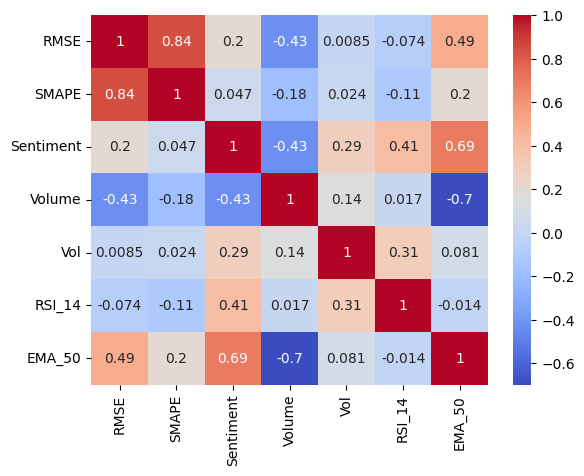

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de corrélation
correlation_matrix = new_df.corr()

# Afficher la heatmap de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [11]:
import statsmodels.api as sm

# Ajouter des termes quadratiques et cubiques
new_df['Sentiment_squared'] = new_df['Sentiment'] ** 2
new_df['Sentiment_cubed'] = new_df['Sentiment'] ** 3

# Régression avec termes non linéaires
X = new_df[['Sentiment', 'Sentiment_squared', 'Sentiment_cubed', 'Volume', 'Vol', 'RSI_14', 'EMA_50']]
y = new_df['RMSE']
# Ajouter une constante pour l'interception
X = sm.add_constant(X)

# Modèle de régression linéaire multiple
model = sm.OLS(y, X).fit()

# Résumé du modèle
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   RMSE   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     30.48
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           1.98e-34
Time:                        15:53:14   Log-Likelihood:                -3889.1
No. Observations:                 453   AIC:                             7794.
Df Residuals:                     445   BIC:                             7827.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -9294.4518   2016.41